# 环境与分布偏移
> 这一节主要探讨数据对于最后训练出的模型的影响, 比如数据中不同分布偏移带来的影响

## 分布偏移的类型
考虑数据分布可能发生变化的各种方式以及挽救模型性能可能采取的措施, 在一个经典的场景中, 假设训练数据是从 $p_s(\mathbf{x}, y)$采样的, 但是测试数据包含从不同分布 $p_T(\mathbf{x},y)$ 中抽取的未标记样本, 如果 $p_S, p_T$之间没有相互关系, 那么无法学习到一个分类器

但是存在算法可以检测这一种偏移, 甚至可以动态调整这一种偏移(也就是测试集和训练集之间的数据分布偏移), 从而提供原始模型的准确度

### 协变量偏移
协变量偏移: 输入的分布可能随时间变换, 但是标签函数 $P(y|\mathbf{X})$没有改变, 比如训练动物分类模型的时候使用的数据未真实动物, 但是用于测试的图片使用卡通动物图片

### 标签偏移
标签偏移: 与协变量偏移相反, 假设标签化边缘概率 $P(y)$ 可以改变, 但是类别条件分布 $P(\mathbf{x} | y)$ 在不同的领域之间保持不变 ; 举例: 症状和时期都会影响疾病类型, 但是时期可能发生变化(测试集的分布发生变化), 这就是标签偏移

### 概念偏移
概念偏移: 当标签的定义发生改变的时候, 可能发生这一种情况

## 分布偏移示例
一些有意思的例子: https://zh.d2l.ai/chapter_multilayer-perceptrons/environment.html

## 分布偏移纠正

### 经验风险和实际风险
假设训练数据为 $\{(\mathbf{x}_1, y_1), ..., (\mathbf{x}_n, y_n)\}$, 那么训练模型的目的就是使得损失最小化也就是:
$$
\min_{f} \frac{1}{n} \sum_{i=1}^{n} l\left(f(\mathbf{x}_i), y_i\right)
$$
这一项被称为**经验风险**(在训练集上的损失函数)

同时对于真实分布 $p(\mathbf{x}, y)$, 抽取的所有数据的总体损失的期望值为:
$$
E_{p(\mathbf{x}, y)}[l(f(\mathbf{x}), y)] = \iint l(f(\mathbf{x}), y) p(\mathbf{x}, y) \, d\mathbf{x} dy
$$
这一个损失针对于实际数据的实际分布, 叫做**实际风险** 

但是大部分时候无法获取到总体数据, 所以只能进行经验风险最小化, 但是实际的目标应该是最小化真实风险

### 协变量偏差纠正
考虑协变量偏差纠正, 假设训练的数据源(目标分布)为$p(\mathbf{x})$, 但是观测值 $\mathbf{x}_i$是从某种源分布 $q(\mathbf{x})$ 中得到的, 但是最后的条件分布保持不变: $p(y|\mathbf{x}) = q(y|\mathbf{x})$, 那么可以使用如下恒等式纠正:
$$
\iint l(f(\mathbf{x}), y) p(y \mid \mathbf{x}) p(\mathbf{x}) \, d\mathbf{x} dy = \iint l(f(\mathbf{x}), y) q(y \mid \mathbf{x}) q(\mathbf{x}) \frac{p(\mathbf{x})}{q(\mathbf{x})} \, d\mathbf{x} dy
$$
所以可以发现这里 $\frac {\mathcal{p}(\mathbf{x_i})}{\mathcal{q}(\mathbf{x_i})}$ 是一个定值:
$$
\mathcal{p}(\mathbf{x_i})
$$
此时只需要把权重 $\beta_i$带入到每一个数据样本 $(\mathbf{x_i}, y_i)$中, 并且使用加权经验风险最小化来训练模型
$$
\underset{f}{\text{minimize}} \frac{1}{n} \sum_{i=1}^{n} \beta_i l\bigl(f(\mathbf{x}_i), y_i\bigr).
$$
所以此时测试集可以人工合成, 之后对于真实的分布进行抽样, 并且只需要考虑特征 $\mathbb{x} - p({\mathbf x})$, 不需要考虑标签, 可以使用 **对数几率回归** 来得到相应的比值:

假设分别从 $p(\mathbf{x})$和 $q({\mathbf(x)})$两个分布中抽取相同数量的样本, 使用 $z$ 表示标签, 从 $p$ 中抽取到数据为 1, 从 $q$ 中抽取到的数据为 -1, 然后, 混合数据集中的概率如下:
$$
P(z = 1 \mid \mathbf{x}) = \frac{p(\mathbf{x})}{p(\mathbf{x}) + q(\mathbf{x})} \text{ and hence } \frac{P(z = 1 \mid \mathbf{x})}{P(z = -1 \mid \mathbf{x})} = \frac{p(\mathbf{x})}{q(\mathbf{x})}.
$$
此时可以使用对数几率回归方法: $P(z = 1 | \mathbf{x}) = \frac {1}{1 + \exp(-h(\mathbf{x}))}$, 那么可以得到 $\beta_i$:
$$
\beta_i = \frac{1 / \bigl(1 + \exp\bigl(-h(\mathbf{x}_i)\bigr)\bigr)}{\exp\bigl(-h(\mathbf{x}_i)\bigr) / \bigl(1 + \exp\bigl(-h(\mathbf{x}_i)\bigr)\bigr)} = \exp\bigl(h(\mathbf{x}_i)\bigr).
$$
整个协方差偏移的纠正过程如下:
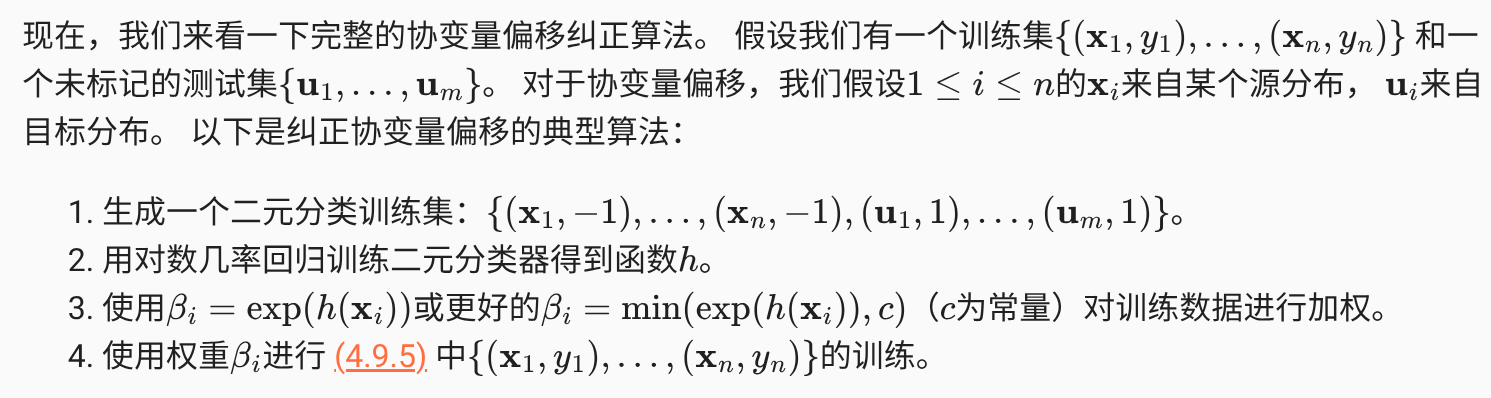

**补充**:

**对数几率回归方法**: 其实就是逻辑回归, 在 `PyTorch` 中, 直接一个线性层 + `nn.CrossEntroyLoss` 作为损失函数进行训练即可

### 标签偏移纠正
标签偏移中, 标签是不规定的, 但是类别条件是固定的, $q(y) \neq p(y)$, 但是类别条件分布不变: $q(\mathbf{x} | y) = p(\mathbf{x} | y)$, 此时可以使用如下恒等式对于真实风险进行更正:
$$
\iint l\bigl(f(\mathbf{x}), y\bigr) p(\mathbf{x} \mid y) p(y) \, d\mathbf{x}dy = \iint l\bigl(f(\mathbf{x}), y\bigr) q(\mathbf{x} \mid y) q(y) \frac{p(y)}{q(y)} \, d\mathbf{x}dy.
$$
重要性权重对应似然标签比率:
$$
\beta_i \stackrel{\text{def}}{=} \frac{p(y_i)}{q(y_i)}.
$$

这一个部分不太清楚:
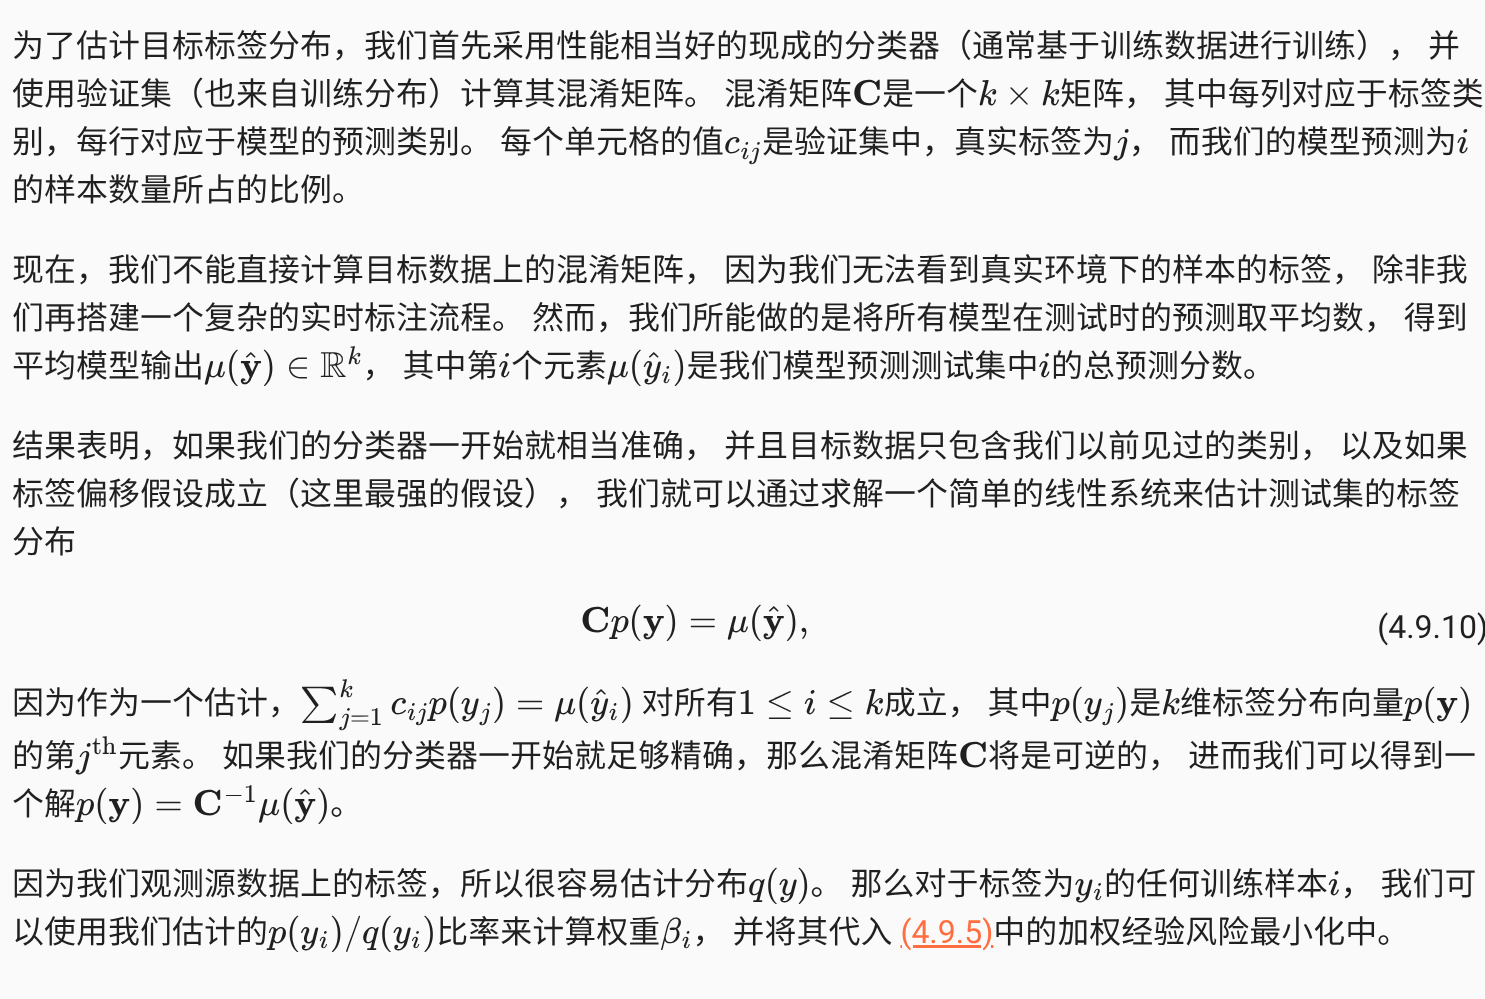

### 概念偏移纠正
基本没有什么现成的解决方法, 可以使用新的数据来更新现有的为网络权重, 而不是从头开始训练

## 学习问题的分类法
### 批量学习
就是之前提到的机器学习方法
### 在线学习
有一点类似于强化学习, 对于一个样本 $(\mathbf{x_i}, y_i)$, 首先给出一个预测值, 之后根据真实值来判断真实值和预测值之间的偏差, 并且根据偏差来决定对应的奖励和损失, 过程如下:
$$
\text{model } f_t \longrightarrow \text{data } \mathbf{x}_t \longrightarrow \text{estimate } f_t(\mathbf{x}_t) \longrightarrow \text{observation } y_t \longrightarrow \text{loss } l(y_t, f_t(\mathbf{x}_t)) \longrightarrow \text{model } f_{t+1} 
$$
### 老虎机
只有有限数量的手臂可以拉动, 采取的行动是有限的
### 控制
也是类似于强化学习, 比如 `PID` 控制算法就是一种不错的选择
### 强化学习
强调如何基于环境而行动, 从而获取到对应的预期利益, 这一个过程中涉及到奖励等机制

## 小结
- 在许多情况下，训练集和测试集并不来自同一个分布。这就是所谓的分布偏移。
- 真实风险是从真实分布中抽取的所有数据的总体损失的预期。然而，这个数据总体通常是无法获得的。经验风险是训练数据的平均损失，用于近似真实风险。在实践中，我们进行经验风险最小化。
- 在相应的假设条件下，可以在测试时检测并纠正协变量偏移和标签偏移。在测试时，不考虑这种偏移可能会成为问题。
- 在某些情况下，环境可能会记住自动操作并以令人惊讶的方式做出响应。在构建模型时，我们必须考虑到这种可能性，并继续监控实时系统，并对我们的模型和环境以意想不到的方式纠缠在一起的可能性持开放态度。